In [1]:
%pip install tensorflow librosa matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 KB 4.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 KB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 KB 9.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 8.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import librosa 
import numpy as np
import matplotlib.pyplot as plt

2024-10-09 20:13:41.230589: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 20:13:41.394652: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-09 20:13:41.590548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 20:13:41.749797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 20:13:41.790915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 20:13:42.050957: I tensorflow/core/platform/cpu_feature_gu

In [3]:
file_path = 'recordings/asistent.wav' 
signal, sample_rate = librosa.load(file_path, sr=None)  # sr=None keeps the original sample rate
print("Sample Rate:", sample_rate)
print("Signal Shape:", signal.shape)

print(signal)


Sample Rate: 44100
Signal Shape: (220160,)
[ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  6.4086914e-04
  3.6621094e-04  4.5776367e-04]


In [4]:
signal_tensor = tf.convert_to_tensor(signal, dtype=tf.float32)
signal_tensor = tf.expand_dims(signal_tensor, 0)  # Add batch dimension

In [5]:
# Parameters for STFT and MFCCs
frame_length = 1024  # 64 ms window
frame_step = 256     # 75% overlap (16 ms step)
fft_length = 1024
num_mel_bins = 80
lower_edge_hertz = 80.0
upper_edge_hertz = 7600.0

# Compute STFT (Short-Time Fourier Transform)
stfts = tf.signal.stft(
    signal_tensor,  # Use the first (and only) element of the batch
    frame_length=frame_length,
    frame_step=frame_step,
    fft_length=fft_length,
    window_fn=tf.signal.hamming_window
)

spectrograms = tf.abs(stfts)

# Mel filterbank
num_spectrogram_bins = stfts.shape[-1]
print("Number of spectogram bins:", num_spectrogram_bins)

linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=num_mel_bins,
    num_spectrogram_bins=num_spectrogram_bins,
    sample_rate=sample_rate,
    lower_edge_hertz=lower_edge_hertz,
    upper_edge_hertz=upper_edge_hertz
)

print(linear_to_mel_weight_matrix.shape[-1:])

Number of spectogram bins: 513
(80,)


In [6]:
# Apply the mel filterbank
mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, axes=1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate([num_mel_bins]))

# Compute log-magnitude mel-spectrograms
log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

# Compute MFCCs from log_mel_spectrograms and take the first 13 coefficients
mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :13]

# Remove batch dimension and convert to NumPy for further processing or visualization
mfccs = mfccs.numpy()

print("MFCCs shape:", mfccs.shape)

MFCCs shape: (1, 857, 13)


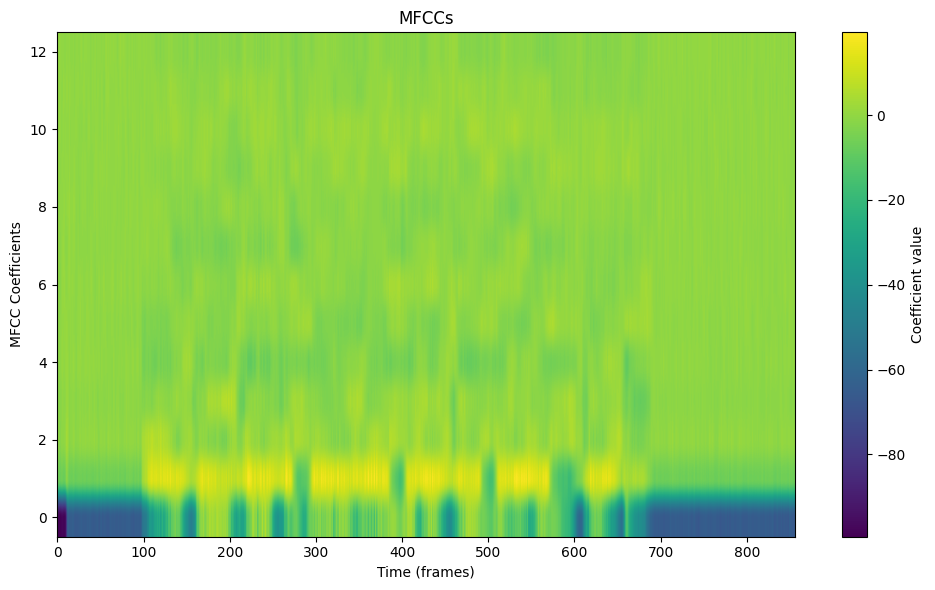

In [7]:
# Remove the batch dimension for visualization
mfccs_reshaped = mfccs[0]  # Shape: (857, 13)

# Plot the MFCCs
plt.figure(figsize=(10, 6))
plt.imshow(mfccs_reshaped.T, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFCCs')
plt.xlabel('Time (frames)')
plt.ylabel('MFCC Coefficients')
plt.colorbar(label='Coefficient value')
plt.tight_layout()
plt.show()

In [8]:
print(mfccs)
np.savetxt("mfccs_python.txt", mfccs[0], fmt='%.6f')  # Save the first (and only) MFCC result
print("MFCCs saved to mfccs_python.txt")

[[[-9.8253761e+01 -6.3592834e+00  1.8993375e-01 ... -6.0343146e-01
    1.6546154e-01  2.7596593e-01]
  [-9.8365341e+01 -5.9134107e+00 -3.3775713e-02 ... -3.3772257e-01
   -2.9440165e-01  4.4826576e-01]
  [-9.9449890e+01 -6.9172125e+00 -1.5330997e+00 ...  6.2243599e-01
   -3.7443304e-01 -8.0229476e-02]
  ...
  [-6.6549057e+01 -7.0233750e+00 -1.2138398e-01 ... -6.7103130e-01
   -2.2278087e-01  1.0704324e+00]
  [-6.4775589e+01 -6.2481251e+00 -8.6312220e-02 ... -2.9450616e-01
    3.7882185e-01  7.9667652e-01]
  [-6.3848522e+01 -6.0778317e+00  3.3636034e-01 ... -1.4276534e-01
    1.8259986e-01  1.7246507e-01]]]
MFCCs saved to mfccs_python.txt
